In [79]:
import torch
from torch import nn
import pandas as pd
from rdkit.Chem import PandasTools
from rdkit import Chem
import deepchem as dc
from numpy import genfromtxt
import numpy as np
import cProfile
import matplotlib.pyplot as plt
from sklearn.model_selection import KFold
from sklearn.metrics import mean_absolute_error, r2_score, mean_squared_error

In [12]:
data = pd.read_csv('data/ETMdata.csv')
print(data['solute'])

0          CC1=C(C=C(C=C1)C(=O)O)C
1          CC1=C(C=C(C=C1)C(=O)O)C
2               C(CCC(=O)O)CC(=O)O
3               C(CCC(=O)O)CC(=O)O
4              C1=CC=C(C=C1)C(=O)O
                  ...             
70                     CS(=O)(=O)N
71         C1=CC=C(C=C1)S(=O)(=O)N
72         C1=CC=C(C=C1)S(=O)(=O)N
73    C1=CC=C2C(=C1)C(=O)NS2(=O)=O
74    C1=CC=C2C(=C1)C(=O)NS2(=O)=O
Name: solute, Length: 75, dtype: object


In [23]:
featurizer = dc.feat.CircularFingerprint(size=512, radius=3)
X = featurizer.featurize(data['solute'])
Y = featurizer.featurize(data['solvent'])
Z = data['pka']

In [74]:
XY = torch.Tensor(np.concatenate((X,Y),axis=1))
Z = torch.Tensor(Z)
#solute/solvent ECFP pairs
print(XY.shape)

torch.Size([75, 1024])


In [70]:
# model definition
epochs = 10

class ECFPnet(nn.Module):
    def __init__(self,n_features,n_hidden):
        super(ECFPnet, self).__init__()
        
        self.FF = nn.Linear(n_features, n_hidden)
        self.out = nn.Linear(n_hidden, 1)
    
    def forward(self,XY):
        z = self.FF(XY)
        z = nn.functional.relu(z)
        output = self.out(z)
        return output

ECFPmodel = ECFPnet(1024,100)
criterion = nn.MSELoss()
optimizer = torch.optim.SGD(ECFPmodel.parameters(), lr=0.0002, momentum=0.9, nesterov=True)

step :  0 loss :  3.9434690475463867
step :  1 loss :  3.782118558883667
step :  2 loss :  3.7193188667297363
step :  3 loss :  3.4582791328430176
step :  4 loss :  3.4081058502197266
step :  5 loss :  3.540025234222412
step :  6 loss :  3.6023199558258057
step :  7 loss :  3.425017833709717
step :  8 loss :  3.2269160747528076
step :  9 loss :  3.2472076416015625
step :  10 loss :  3.109071969985962
step :  11 loss :  3.121325969696045
step :  12 loss :  2.9824013710021973
step :  13 loss :  2.8050475120544434
step :  14 loss :  2.6685967445373535
step :  15 loss :  2.631087303161621
step :  16 loss :  2.5127148628234863
step :  17 loss :  2.491887331008911
step :  18 loss :  2.1153323650360107
step :  19 loss :  1.996466875076294


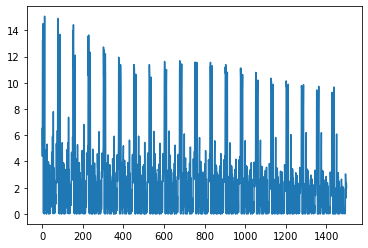

In [72]:
epochs = 20
losslist = []
for t in range(epochs):
    for b in range(XY.shape[0]):
        target = Z[b] 
        output = ECFPmodel(XY[b]) 
        loss = criterion(output, target)  
        losslist.append(loss.item())
        
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()
    print('step : ' , t , 'loss : ' , loss.item())
    
plt.plot(losslist)

In [96]:
#crossval
num_epochs = 200
k_folds = 5
kfold = KFold(n_splits=k_folds, shuffle=True)

dataset = torch.utils.data.TensorDataset(XY, Z)
results = []

for fold, (train_ids, test_ids) in enumerate(kfold.split(dataset)):   
    train_subsampler = torch.utils.data.SubsetRandomSampler(train_ids)
    test_subsampler = torch.utils.data.SubsetRandomSampler(test_ids)
    trainloader = torch.utils.data.DataLoader(dataset, batch_size=5, sampler=train_subsampler)
    
    network = ECFPnet(1024,512)
    optimizer = torch.optim.Adam(network.parameters(), lr=1e-4)
    
    for epoch in range(0, num_epochs):
        for i, data in enumerate(trainloader, 0):
            inputs, targets = data
            optimizer.zero_grad()
            outputs = network(inputs)
            loss = criterion(outputs, targets)
            loss.backward()
            optimizer.step()
            current_loss += loss.item()

    with torch.no_grad():
        outputs = network(XY[test_ids])
        targets = Z[test_ids]
        results.append(mean_absolute_error(targets, outputs))

print(f'K-FOLD CROSS VALIDATION RESULTS FOR {k_folds} FOLDS')
print('--------------------------------')
print(f'all MAE:', results)
print(f'Average MAE: {sum(results)/len(results)}')

/Users/u6676643/opt/anaconda3/lib/python3.8/site-packages/torch/nn/modules/loss.py:446: UserWarning: Using a target size (torch.Size([5])) that is different to the input size (torch.Size([5, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/Users/u6676643/opt/anaconda3/lib/python3.8/site-packages/torch/nn/modules/loss.py:446: UserWarning: Using a target size (torch.Size([5])) that is different to the input size (torch.Size([5, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/Users/u6676643/opt/anaconda3/lib/python3.8/site-packages/torch/nn/modules/loss.py:446: UserWarning: Using a target size (torch.Size([5])) that is different to the input size (torch.Size([5, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure the

K-FOLD CROSS VALIDATION RESULTS FOR 5 FOLDS
--------------------------------
all MAE: [3.4068625, 3.768413, 2.8325968, 5.22598, 3.092593]
Average MAE: 3.66528902053833
